# Classification with a random forest

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)

from sqlalchemy import create_engine

def create_connection():
    host = 'localhost'
    port = '3333'
    return create_engine(f"postgresql://infocup@{host}:{port}/infocup")

In [2]:
con = create_connection()

time_price = con.execute("""select station_id, time_stamp, price 
from prices_sampled 
where time_stamp > '2017-06-01' 
and station_id < 500
and station_id not in (21, 67, 68, 69, 72, 90, 91, 92, 100, 130, 131, 132, 133, 184, 218, 219, 296, 305, 353, 354, 362, 382, 398, 410, 411, 430, 434, 439, 478, 479, 483, 491)
and date_part('hour', time_stamp)::int %% 8 = 0""")
tp = [[t[0], t[1], t[2]] for t in time_price]

Hierarchical Clustering inspired by: http://badassdatascience.com/2014/12/31/clustering-stocks-1/

In [3]:
ids = set([t[0] for t in tp])

prices_time_series = {id : [] for id in ids}

for id in ids:
    prices_time_series[id].append([t[2] for t in tp if id == t[0]])

In [4]:
import scipy.stats

# Calculate R
new_ids = sorted(prices_time_series.keys())
R_dict = {i: {} for i in range(0, len(new_ids))}
for i in range(0, len(new_ids)):
    for j in range(i, len(new_ids)):
        id_i = new_ids[i]
        id_j = new_ids[j]
        R = 1.0
        if id_i != id_j: 
            if len(prices_time_series[id_i][0]) != len(prices_time_series[id_j][0]):
                # TODO: how to handle missing prices?
                print('{} and {} are not in the same shape.'.format(id_i, id_j))
                break
            R = scipy.stats.pearsonr(prices_time_series[id_i][0], prices_time_series[id_j][0])[0]
        R_dict[i][j] = R

In [5]:
# create the distance matrix
distance_matrix = np.zeros([len(new_ids), len(new_ids)])
for i in R_dict.keys():
    for j in R_dict[i].keys():
        similarity = R_dict[i][j] + 1. #range 0 to 2
        distance = (-1 * (similarity - 2.0)) / 2.0
        distance_matrix[i][j] = distance
        distance_matrix[j][i] = distance

In [6]:
import scipy.cluster.hierarchy
# create the linkage:
Z = scipy.cluster.hierarchy.linkage(distance_matrix, method='average')

# function to set blank dendrogram labels
def llf(id):
    return ''

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  app.launch_new_instance()


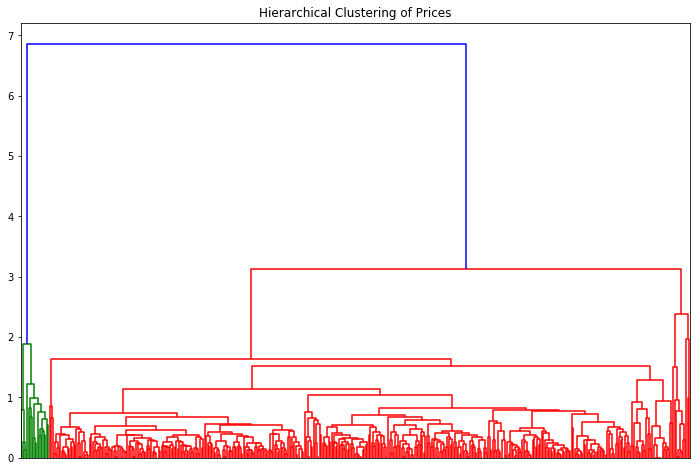

In [8]:
# plot

plt.figure(figsize=(12, 8))

scipy.cluster.hierarchy.dendrogram(Z, leaf_label_func=llf)
plt.title('Hierarchical Clustering of Prices')
plt.show()


50
1
25.5
50


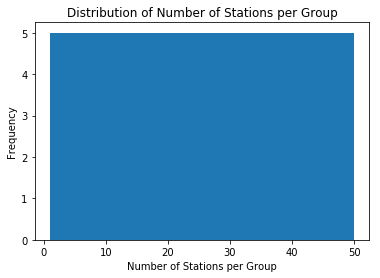

In [15]:
# flatten
number_of_groups_to_use = [50]
for n in number_of_groups_to_use:
    T = scipy.cluster.hierarchy.fcluster(Z, n, criterion="maxclust")
    counts = {}
    for i, t in enumerate(T):
        if t not in counts:
            counts[t] = 0
        counts[t] += 1
    counts_list = []
    for c in counts.keys():
        counts_list.append(c)
 
    # output
    print()
    print(n)
    print(np.min(counts_list))
    print(np.median(counts_list))
    print(np.max(counts_list))
    plt.hist(counts_list)
    plt.title('Distribution of Number of Stations per Group')
    plt.xlabel('Number of Stations per Group')
    plt.ylabel('Frequency')
    plt.show()